# RGI08 (Scandinavia)

F. Maussion & S. Galos

Same as RGI6, with exception of an area in Northern Norway.

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 8

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '07_rgi60_Scandinavia.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
362,152,188.1,Hansson,Brown,2005,Sweden,2002,2002,2002
363,106,72.7,Hansson,Brown,2005,Sweden,2002,2002,2002
364,9,2.8,Hansson,Brown,2005,Sweden,2002,2002,2002
365,4,0.9,Hansson,Brown,2005,Sweden,2002,2002,2002
611,3146,2687.8,"Andreassen, Winsvold",Winsvold,2012,Norway,2006,1999,2006
695,140,95.6,"Andreassen, Stokes",Andreassen,2018,Norway,2014,2014,2014
717,234,289.3,Baumann,Bauman,2021,Norway,1750,1750,1750
725,2383,1649.1,"Andreassen, Winsvold",Andreassen,2018,Norway,1988,1988,1997
733,219,101.9,"Andreassen, Leigh",Andreassen,2020,Norway,1989,1989,1989


- 611 is RGI6 but for Norway only (many outlines stop at the border...)
- 362 is RGI6 in Sweden (middle Lappland)
- 363 is RGI6 in Sweden (northern Lappland)
- 364 is RGI6 in Sweden (southern Lappland)
- 365 is RGI6 in Sweden (Jämtland)
- 733 to 742: new regions for parts of northern norway. We decide to use 738 in replacement for 611 where possible

In [6]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

For now, we stick to reproducing RGI6:

In [10]:
# do that based on relevant submission IDs (611, 362, 363, 364, 365)
rgi7 = (shp.loc[shp['subm_id'].isin([611, 362, 363, 364, 365])]).copy()
rgi7['is_rgi6'] = True

In [11]:
# Size filter?
print(len(rgi7))
rgi7 = size_filter(rgi7)
len(rgi7)

3417


3416

OK now take care of the new inventory. We need to make a geometry around it for selection: 

In [14]:
new = (shp.loc[shp['subm_id'].isin([738])]).copy()
new['is_rgi6'] = False

# Size filter?
print(len(new))
new = size_filter(new)
len(new)

237


237

Make a box aroun the region (I checked in GIS, it's ok to do so):

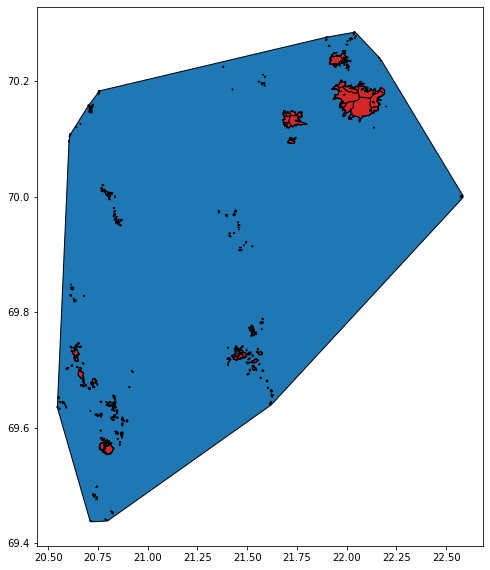

In [17]:
import shapely.geometry as shpg
hull = gpd.GeoDataFrame({'geometry':[shpg.MultiPolygon(new.geometry.values).convex_hull]})
hull.crs = new.crs

f, ax = plt.subplots(figsize=(8, 12))
hull.plot(ax=ax, edgecolor='k');
new.plot(ax=ax, facecolor='C3', edgecolor='k');

In [18]:
# Remove all old rgi outlines
rp = rgi7.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi7.index

# Find non overlying polygons
difference = gpd.overlay(rp, hull, how='difference')

# Create new rgi
rgi7 = rgi7.loc[difference['orig_index']].copy()
assert rgi7.anlys_id.isin([355145]).sum() == 0  # This is the only geometry down there which might have not fit in the polygon

In [19]:
# Merge
rgi7 = pd.concat([rgi7, new])

### Some sanity checks 

In [20]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
362,152,152
363,106,106
364,9,9
365,4,4
611,2998,2998
738,237,237


In [21]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

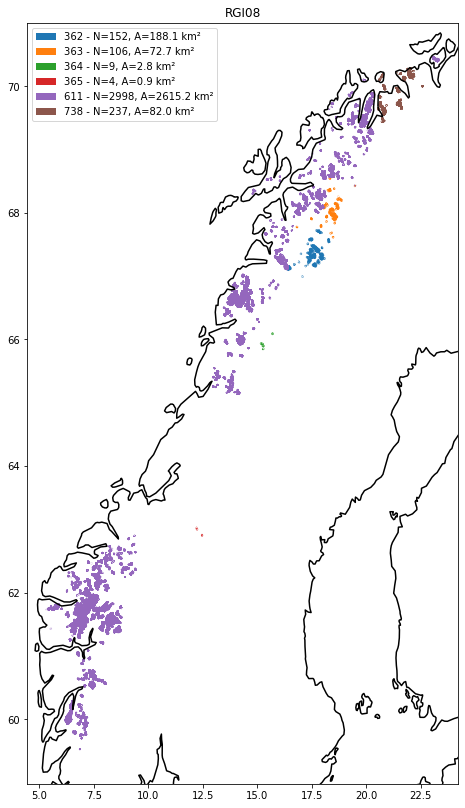

In [23]:
plot_map(rgi7, reg, loc='upper left', linewidth=2)

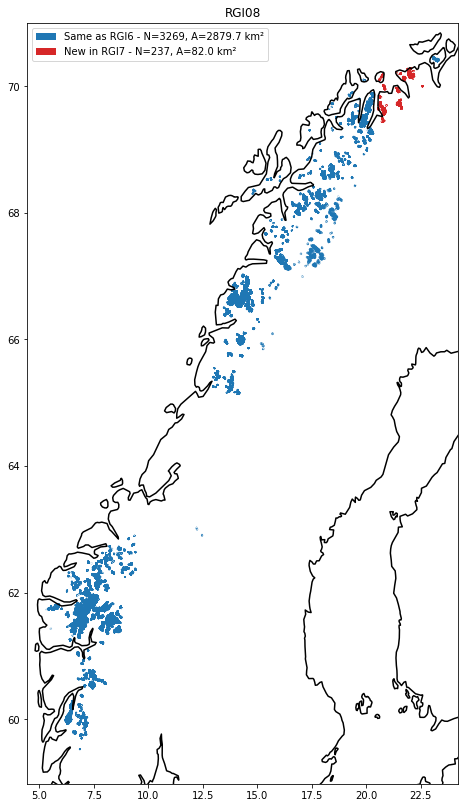

In [24]:
plot_map(rgi7, reg, loc='upper left', linewidth=2, is_rgi6=True)

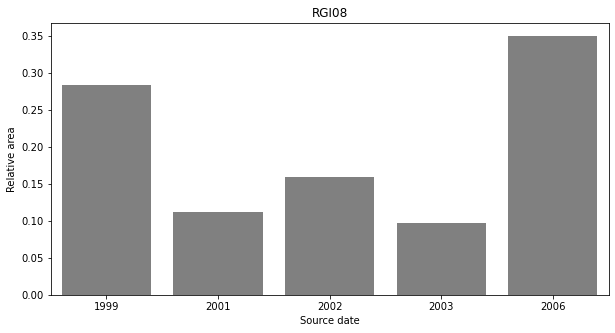

In [25]:
plot_date_hist(rgi7, reg)

### Text for github

In [26]:
fgh = sdf.T
fgh

subm_id,362,363,364,365,611,738
N,152,106,9,4,2998,237
A,188.1,72.7,2.8,0.9,2615.2,82.0
analysts,Hansson,Hansson,Hansson,Hansson,"Andreassen, Winsvold","Andreassen, Leigh"
submitters,Brown,Brown,Brown,Brown,Winsvold,Andreassen
release_date,2005,2005,2005,2005,2012,2020
geog_area,Sweden,Sweden,Sweden,Sweden,Norway,Norway
src_date_mode,2002,2002,2002,2002,2006,1999
src_date_min,2002,2002,2002,2002,1999,1999
src_date_max,2002,2002,2002,2002,2006,1999


In [27]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 362     | 363     | 364     | 365     | 611                  | 738               |
|:--------------|:--------|:--------|:--------|:--------|:---------------------|:------------------|
| N             | 152     | 106     | 9       | 4       | 2998                 | 237               |
| A             | 188.1   | 72.7    | 2.8     | 0.9     | 2615.2               | 82.0              |
| analysts      | Hansson | Hansson | Hansson | Hansson | Andreassen, Winsvold | Andreassen, Leigh |
| submitters    | Brown   | Brown   | Brown   | Brown   | Winsvold             | Andreassen        |
| release_date  | 2005    | 2005    | 2005    | 2005    | 2012                 | 2020              |
| geog_area     | Sweden  | Sweden  | Sweden  | Sweden  | Norway               | Norway            |
| src_date_mode | 2002    | 2002    | 2002    | 2002    | 2006                 | 1999              |
| src_date_min  | 2002    | 2002    | 2002    | 2002    | 1999                 | 1999      

## Write out and tar 

In [28]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI08.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI08'], returncode=0)


## Consistency check with RGI6 

In [32]:
# load reference data
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [33]:
len(rgi7), len(rgi6)

(3269, 3417)

In [34]:
# Select only the relevant parts for the rest of the tests:
rp = rgi7.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi7.index
difference = gpd.overlay(rp, hull, how='difference')
rgi7 = rgi7.loc[difference['orig_index']].copy()

rp = rgi6.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi6.index
difference = gpd.overlay(rp, hull, how='difference')
rgi6 = rgi6.loc[difference['orig_index']].copy()

Test the areas:

In [35]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [36]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 2879.6860401902245
Area RGI6 (km2) 2876.547
Area RGI6 computed by us (km2) 2876.529031807965
diff areas RGI6 - RGI7 computed by us (km2) -3.157008382259369


So, the difference is small... BUT there are issues at the Norway-Sweden border. Screenshots:

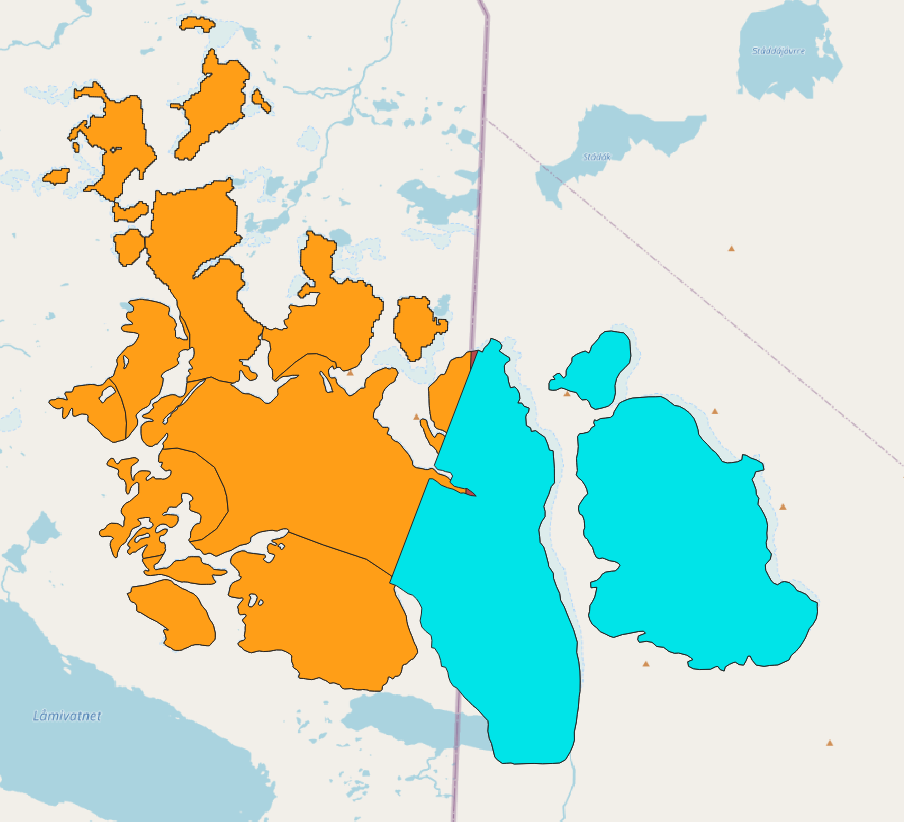

Note that RGI6 has some corrections:

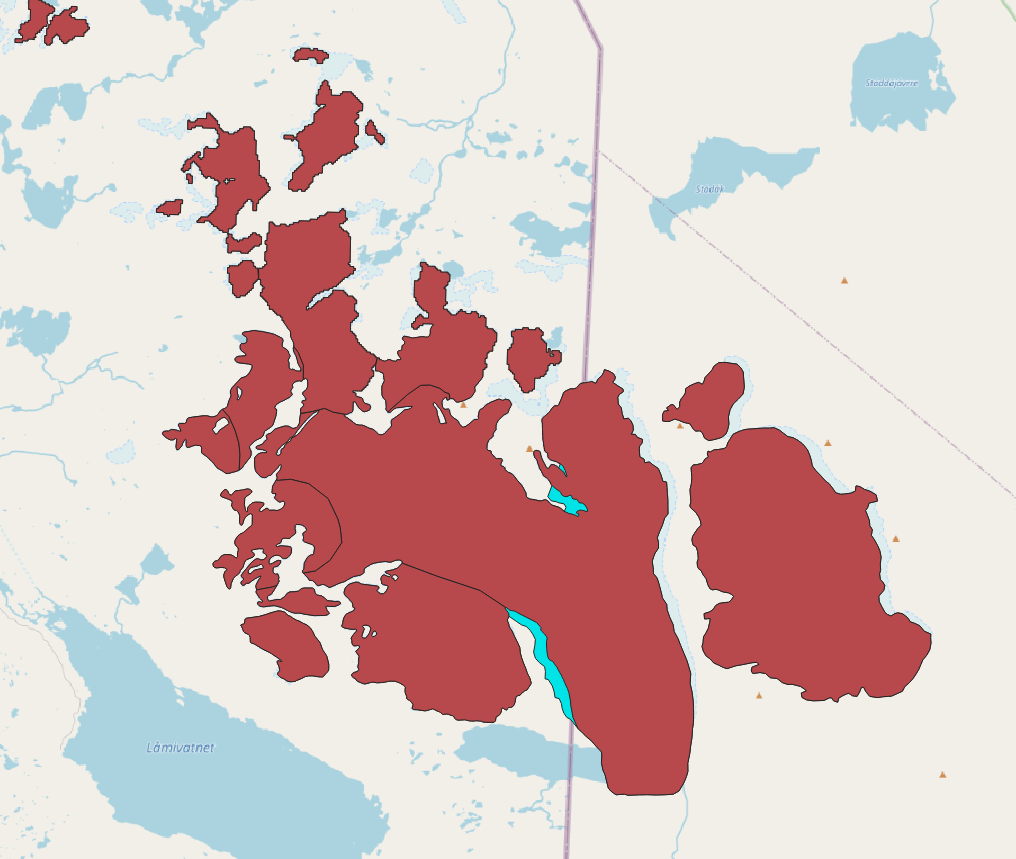

This would be a way to address the problem, but it needs ingested in GLIMS (https://trello.com/c/gprXN5RU):

Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI08.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI08'], returncode=0)


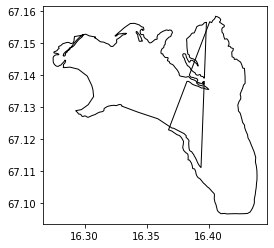

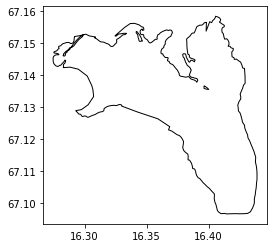

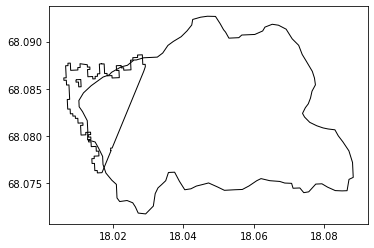

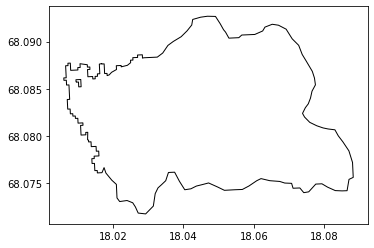

In [37]:
# Write the output so that we can eventually retire the outlines in GLIMS
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

for ids in [[354438, 55064], [354713, 55092]]:
    tomerge = rgi7.loc[rgi7.anlys_id.isin(ids)]
    tomerge.plot(facecolor='none', edgecolor='k');
    new = tomerge.dissolve()
    new.plot(facecolor='none', edgecolor='k');
    new['area'] = new.to_crs({'proj':'cea'}).area 
    
    # Store
    tomerge.to_file(dd + f'{new.glac_id[0]}_toreplace.shp')
    new.to_file(dd + f'{new.glac_id[0]}_merged.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))